# Activation Patching

In [132]:
import torch, transformer_lens, itertools, random
from functools import partial
torch.set_grad_enabled(False)

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

from tqdm import tqdm
from measureLM import helpers, measuring, synth_data, patching, visualizing

In [223]:
import matplotlib as mpl
import seaborn as sns

import numpy as np
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from measureLM import helpers

matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

def plot_heatmap(array, title='Patching Effect', xticklabels=["attn_out", "mlp_out"], cmap="binary"):
    titlefont, labelsize = 12, 10
    array_abs_max = np.max(np.abs(array))
    fig, ax = plt.subplots(1, 1, figsize=(2, 4), gridspec_kw={'hspace': 0.4})
    #ax = sns.heatmap(array, vmin=-array_abs_max, center=0, vmax=array_abs_max, cmap=mpl.colormaps[cmap], xticklabels=xticklabels, square=False)
    ax = sns.heatmap(array, cmap=mpl.colormaps[cmap], xticklabels=xticklabels, square=False)
    ax.set_title(title, fontsize=titlefont, color="black", loc='center', y=1.22)
    ax.set_ylabel('layers', fontsize=labelsize)

    mean_effect = list(map(lambda x: "%.3f" % x, list(array.mean(0))))
    max_effect = list(map(lambda x: "%.3f" % x, list(array.max(0))))
    #min_effect = list(map(lambda x: "%.3f" % x, list(array.min(0))))
    for i, x_tick_label in enumerate(ax.get_xticklabels()):
        ax.text(x_tick_label.get_position()[0] - 0.5, -0.5, f"max:\n{max_effect[i]}", fontsize=labelsize,
        color="black", verticalalignment='bottom')
        ax.text(x_tick_label.get_position()[0] - 0.5, -3.0, f"mean:\n{mean_effect[i]}", fontsize=labelsize,
        color="black", verticalalignment='bottom')
        #ax.text(x_tick_label.get_position()[0] - 0.5, -0.2, f"min:\n{min_effect[i]}", fontsize=labelsize,
        #color="black", verticalalignment='bottom')
    plt.show()
    

## Data and Model

In [3]:
model_name = "gpt2-medium"
model = measuring.load_model(model_name=model_name, device="mps")

Using pad_token, but it is not set yet.


Loaded pretrained model gpt2-medium into HookedTransformer
Moving model to device:  mps


In [303]:
def construct_bias_context_pairs(df, prompt=None, pos_prefix=None, neg_prefix=None, seed=0):

    random.seed(seed)
    prompt = "The relationship between {ent1} and {ent2} is"
    context = "{ent1} {pred} {ent2}."
    predicates = ["loves", "hates", "likes", "dislikes", "tolerates", "accepts", "supports", "speaks in favour of"]

    ent1_ent2_pairs = []
    ent1_ent2 = list(zip(df["ent1"].to_list(), df["ent2"].to_list()))
    for ent1, ent2 in ent1_ent2:
        random.shuffle(predicates)
        pred = predicates[0]
        #no_context_prompt = measuring.form_prompt(f"{prompt}", {"ent1": ent1, "ent2": ent2})
        context_ents = measuring.form_prompt(f"{context} {prompt}", {"ent1": ent1, "pred": pred, "ent2": ent2})
        context_anonym = measuring.form_prompt(f"{context} {prompt}", {"ent1": "entity A", "pred": pred, "ent2": "entity B"})
        ent1_ent2_pairs.append((context_anonym, context_ents))

    print(f"{len(ent1_ent2_pairs)} data points")
    return ent1_ent2_pairs

In [304]:
scales = ["positive", "negative"]
scale_idx = measuring.get_logit_indices(scales, model)

df = synth_data.load_synth_data(n=10, seed=0)
context_pairs = construct_bias_context_pairs(df, seed=0)
context_pairs

10 data points


[('entity A tolerates entity B. The relationship between entity A and entity B is',
  'John Lennon tolerates Paul McCartney. The relationship between John Lennon and Paul McCartney is'),
 ('entity A hates entity B. The relationship between entity A and entity B is',
  'Harry Potter hates Hermione Granger. The relationship between Harry Potter and Hermione Granger is'),
 ('entity A accepts entity B. The relationship between entity A and entity B is',
  'Kuomintang accepts Chinese Communist Party. The relationship between Kuomintang and Chinese Communist Party is'),
 ('entity A supports entity B. The relationship between entity A and entity B is',
  'Sheriff of Nottingham supports Robin Hood. The relationship between Sheriff of Nottingham and Robin Hood is'),
 ('entity A supports entity B. The relationship between entity A and entity B is',
  'Gauls supports Rome. The relationship between Gauls and Rome is'),
 ('entity A accepts entity B. The relationship between entity A and entity B is

## Get Patches for Bias and Context

In [305]:
from functools import partial

from transformer_lens.hook_points import (
    HookedRootModule,
    HookPoint,
)

def run_patching_loop(model, prompt_pairs, scale_idx):
    all_vector_scale, all_vector_dir = [], []
    for (prompt_1, prompt_2) in tqdm(prompt_pairs, position=0, leave=False):
        old_logits, old_activs = measuring.prompt_with_cache(model, prompt_1, logit_idx=scale_idx, norm=False)
        new_logits, new_activs = measuring.prompt_with_cache(model, prompt_2, logit_idx=scale_idx, norm=False)
        vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, prompt_1, scale_idx)

        all_vector_scale.append(vector_scale)
        all_vector_dir.append(vector_dir)

    vector_scale = torch.stack(all_vector_scale).detach()  ## shape: prompt, layers, att vs mlp
    vector_dir = torch.stack(all_vector_dir).detach()  ## shape: prompt, new vs old, layers, att vs mlp, emb dim
    return vector_scale, vector_dir


def patch_hook_point(old_activs, hook: HookPoint, new_activs, hook_layer_name, extract_tok_idx=-1,
                     insert_tok_idx=None):
    # print(f'patching {hook.name} <-- {hook_layer_name}')
    if extract_tok_idx is None or extract_tok_idx == -1:
        extract_tok_idx = (0, -1)
    if insert_tok_idx is None:
        insert_tok_idx = extract_tok_idx
    new_activs_hook = new_activs[hook_layer_name] 
    vector_direction.append(torch.stack([old_activs[insert_tok_idx].detach(), new_activs_hook[extract_tok_idx]]))
    old_activs[insert_tok_idx] = new_activs_hook[extract_tok_idx]


def patch_activs(model, old_logits, new_logits, new_activs, prompt, logit_idx):
    n_layers = model.cfg.n_layers
    hook_names = ["attn_out", "mlp_out"]

    effect_strength = torch.zeros(n_layers, len(hook_names), device=model.cfg.device)
    global vector_direction
    vector_direction = []

    #for layer in tqdm(range(n_layers), position=1, leave=True):
    for layer in range(n_layers):
        for hook_i, hook_name in enumerate(hook_names):
            hook_layer_name = transformer_lens.utils.get_act_name(hook_name, layer)
            patch_layers_fn = [(hook_layer_name, partial(patch_hook_point, new_activs=new_activs, hook_layer_name=hook_layer_name))]
            patched_logits = model.run_with_hooks(prompt, fwd_hooks=patch_layers_fn, reset_hooks_end=True)

            ## get measurement change
            patched_logits = measuring.select_logits(patched_logits, logit_idx, norm=False)

            ## store effect strength
            patched_logit_diff = (patched_logits[..., 0] - patched_logits[..., 1])
            old_logit_diff = measuring.compute_scale_val(old_logits, scale_val_type="diff")
            new_logit_diff = measuring.compute_scale_val(new_logits, scale_val_type="diff")
            #effect_strength[layer, hook_i] = (patched_logit_diff - old_logit_diff) / (new_logit_diff - old_logit_diff)
            effect = (patched_logit_diff - old_logit_diff) / (new_logit_diff - old_logit_diff)
            #effect = torch.abs(patched_logits[..., 0]-old_logits[..., 0])
            effect_strength[layer, hook_i] = torch.abs(effect)

    vector_direction = torch.stack(vector_direction)
    vector_direction = torch.movedim(vector_direction, 0, 1)
    vector_direction = vector_direction.view(2, model.cfg.n_layers, -1, model.cfg.d_model)
    return effect_strength.detach(), vector_direction.detach()


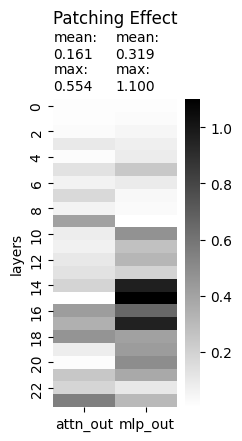

In [306]:
#old_prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
old_prompt = ["Harry Potter loves Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
new_prompt = ["entity A loves entity B. The relationship between entity A and entity B is"]
#new_prompt = ["The relationship between entity A and entity B is"]

old_logits, old_activs = measuring.prompt_with_cache(model,old_prompt,logit_idx=scale_idx,norm=False)
new_logits, new_activs = measuring.prompt_with_cache(model,new_prompt,logit_idx=scale_idx,norm=False)

vector_scale, vector_dir = patch_activs(model, old_logits, new_logits, new_activs, old_prompt, scale_idx)
plot_heatmap(vector_scale.cpu().numpy(), cmap="binary")

In [307]:
context_scale, context_dir = run_patching_loop(model, context_pairs, scale_idx)

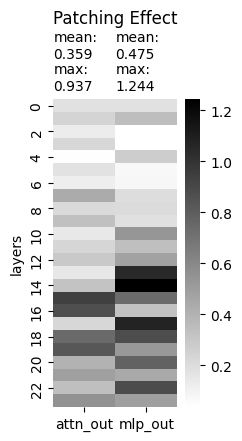

In [309]:
plot_heatmap(context_scale.mean(0).cpu().numpy(), cmap="binary")

## Apply Patches

### Before Patching

In [365]:
#prompt = ["The relationship between Harry Potter and Ronald Weasley is"]
prompt = ["Harry Potter loves Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
#prompt = ["Harry Potter hates Ronald Weasley. The relationship between Harry Potter and Ronald Weasley is"]
#prompt = ["Ben loves Joe. The relationship between Ben and Joe is"]

#prompt = ["The relationship between entity B and entity A is"]
#prompt = ["entity A loves entity B. The relationship between entity B and entity A is"]
#prompt = ["entity A hates entity B. The relationship between entity A and entity B is"]

logits, activs = measuring.prompt_with_cache(model,prompt,logit_idx=scale_idx,norm=True)
scale_v = logits[..., 0]
scale_v

tensor([0.5889], device='mps:0')

### After Patching

In [373]:
def prepare_context(dir_vec, scale_vec):
    a, b = dir_vec[:, 0], dir_vec[:, 1]
    
    # a / |a| * |b| * (a * b / (|a| * |b|))
    # --> a * (a * b / |a|**2)
    dir_vec = torch.einsum("...nlcd,...nlcd->...nlc", a, b) / (torch.norm(a, dim=-1) ** 2)
    dir_vec = b-torch.einsum("...nlcd,...nlc->...nlcd", a, dir_vec)

    dir_vec_scale = torch.einsum("...nlcd,...nlc->...nlcd", dir_vec, scale_vec)
    dir_vec_scale = dir_vec_scale.mean(0)
    return dir_vec_scale


def control_hook_point(activs, hook: HookPoint, dir_scale, alpha): 
    i = int(hook.layer())
    j = {"hook_attn_out":0, "hook_mlp_out":1}[hook.name.split(".")[2]]
    patched_activs = activs[...,-1,:] + (alpha * (dir_scale[i,j,:]))
    activs[...,-1,:] = patched_activs

def control_bias_context(model, prompt, dir_scale, alpha=1.0):
    
    patch_hook_fn = partial(control_hook_point, dir_scale=dir_scale, alpha=alpha)   
    patch_layers_fn = [(lambda name: name.endswith("attn_out") or name.endswith("mlp_out"), patch_hook_fn)]
    
    patch_logits = model.run_with_hooks(prompt, fwd_hooks=patch_layers_fn, return_type="logits", reset_hooks_end=True)
    return patch_logits

In [374]:
context_dir_scale = prepare_context(context_dir,context_scale)

context_patch_logits = control_bias_context(model, prompt, context_dir_scale, alpha=1)
context_patch_logits = measuring.select_logits(context_patch_logits[:,-1,:], scale_idx, norm=True)

context_scale_v = context_patch_logits[..., 0]
context_scale_v

tensor(0.5601, device='mps:0')